In [1]:
# !pip install pandasql

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from scipy.stats import ttest_ind
from scipy.stats.stats import pearsonr
pysqldf = lambda q: sqldf(q, globals())
from sklearn.manifold import TSNE
import time
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

%matplotlib inline 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/top-spotify-songs-from-20102019-by-year/top10s.csv


In [3]:
data = pd.read_csv("../input/top-spotify-songs-from-20102019-by-year/top10s.csv", encoding='ISO-8859-1')
data.head(5)

,Unnamed: 0,title,artist,top genre,year,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop
0,1,"Hey, Soul Sister",Train,neo mellow,2010,97,89,67,-4,8,80,217,19,4,83
1,2,Love The Way You Lie,Eminem,detroit hip hop,2010,87,93,75,-5,52,64,263,24,23,82
2,3,TiK ToK,Kesha,dance pop,2010,120,84,76,-3,29,71,200,10,14,80
3,4,Bad Romance,Lady Gaga,dance pop,2010,119,92,70,-4,8,71,295,0,4,79
4,5,Just the Way You Are,Bruno Mars,pop,2010,109,84,64,-5,9,43,221,2,4,78


### Possible Analyses
---
1. Genre
2. How BPM affects the Popularity
3. How BPM has changed over the decade
4. Relationship between Genre and BPM
5. Relationship between Loudness and Popularity
6. Have the song become louder over the decade
7. Most Consistent Artist
8. Most popular artist
9. Correlation between loudness and Energy and BPM and energy and popularity
10. Spch and popularity, spch and artist
11. Topic of the song(Depends on title using NLP)
12. cluster the songs using topic, genre, artist bpm-spch
---
More can be added later on!

In [4]:
print(pysqldf("""select year, count(distinct title) from data
group by 1
order by 2"""))

   year  count(distinct title)
0  2019                     31
1  2012                     35
2  2010                     51
3  2011                     53
4  2014                     58
5  2018                     64
6  2017                     65
7  2013                     71
8  2016                     80
9  2015                     94


In [5]:
print("top genre on spotify's top 50 chart is")
print(pysqldf("select `top genre`, count(*) as cnt from data \
                    group by 1 \
                    order by 2 desc").head())

top genre on spotify's top 50 chart is
       top genre  cnt
0      dance pop  327
1            pop   60
2   canadian pop   34
3       boy band   15
4  barbadian pop   15


### The most common genre on the chart is Dance pop which contains roughly 50% of the songs on the chart

In [6]:
data_filter = pysqldf("""select artist, year, count(distinct title) as cnt from data
                      group by 1,2 
                      order by 2,1""")
data_filter = pd.pivot_table(data_filter, index = 'artist', columns = 'year', 
                   values = 'cnt', aggfunc = np.sum, fill_value = 0)
data_filter['total_songs'] = data_filter.sum(axis = 1)
data_filter['mean_songs'] = data_filter.loc[:,data_filter.columns != 'total_songs'].mean(axis = 1)
data_filter.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,total_songs,mean_songs
artist,,,,,,,,,,,,
3OH!3,1,0,0,0,0,0,0,0,0,0,1,0.1
5 Seconds of Summer,0,0,0,0,1,0,0,0,0,0,1,0.1
A Great Big World,0,0,0,0,1,0,0,0,0,0,1,0.1
Adam Lambert,2,0,0,0,0,0,0,0,0,0,2,0.2
Adele,0,2,1,0,0,1,4,2,0,0,10,1.0


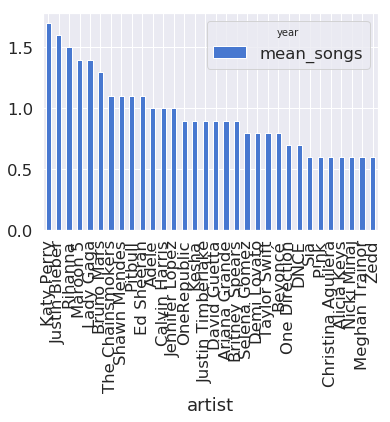

In [7]:
data_filter.loc[data_filter['mean_songs'] > 0.5,['mean_songs']].sort_values('mean_songs', ascending = False).plot(kind = 'bar')

### Katy Perry has been the most popular artist over the decade. Atleast 1.6 songs created by Katy Perry have charted on the Top 50 list over the decade.

### Is there a trend in her popularity?

year  2010  2011  2012  2013  2014  2015  2016  2017  2018  2019
86       2     3     3     1     3     1     1     3     0     0


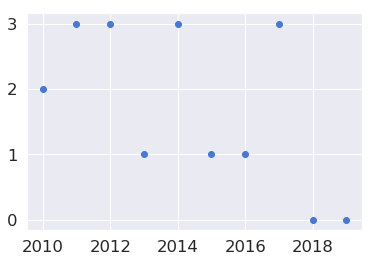

In [8]:
cols = list(set(data_filter.columns) - set( ['artist','year','total_songs', 'mean_songs']))
cols = sorted(cols)
y = data_filter.reset_index()[data_filter.reset_index()['artist'] == 'Katy Perry'][cols]
plt.scatter(x = cols, y = y)
print(y)

### Last two years of the decade were not really great for Katy Perry, non of her songs charted on the top 50 list of the year.

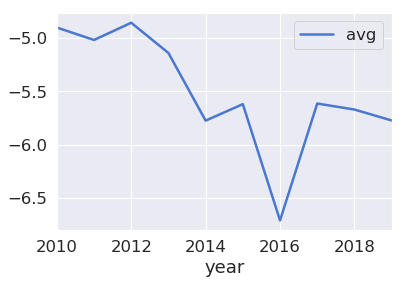

In [9]:
data_filter = pysqldf("""select year, avg(dB) as avg,max(dB) as max, min(dB) as min 
from data group by 1
order by 1""")

data_filter.set_index('year')[['avg']].plot()

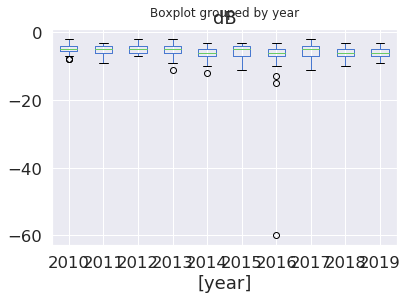

In [10]:
data[['dB', 'year']].boxplot(by = 'year')

In [11]:
print(pysqldf("""select title,artist,`top genre` from data
where dB < -10"""))

                           title                  artist     top genre
0                  Foolish Games                   Jewel  alaska indie
1                      Partition                 Beyoncé     dance pop
2   What Do You Mean? - Acoustic           Justin Bieber  canadian pop
3                        St Jude  Florence + The Machine       art pop
4                          Start             John Legend    neo mellow
5  Beautiful Birds (feat. Birdy)               Passenger      folk-pop
6              Million Years Ago                   Adele  british soul
7                           Love            Lana Del Rey       art pop


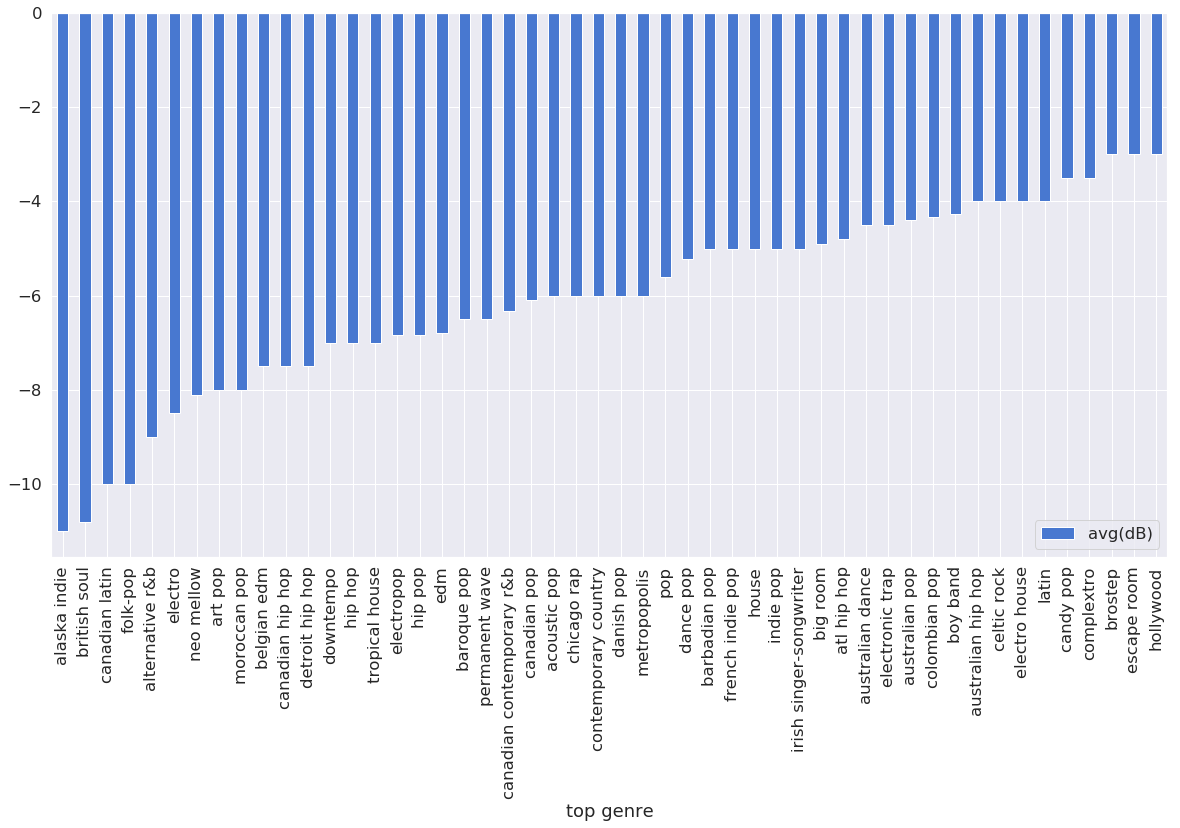

In [12]:
data_filter = pysqldf("""select `top genre`, avg(dB) from data
group by 1
order by 2""")
data_filter.set_index('top genre').plot(kind = "bar", figsize = (20,10))

In [13]:
corr, p = pearsonr(x = data['dB'], y = data['pop'])
print("Correlation coefficient is %0.4f with a p-value of %0.2f" %(corr, p))

Correlation coefficient is 0.1569 with a p-value of 0.00


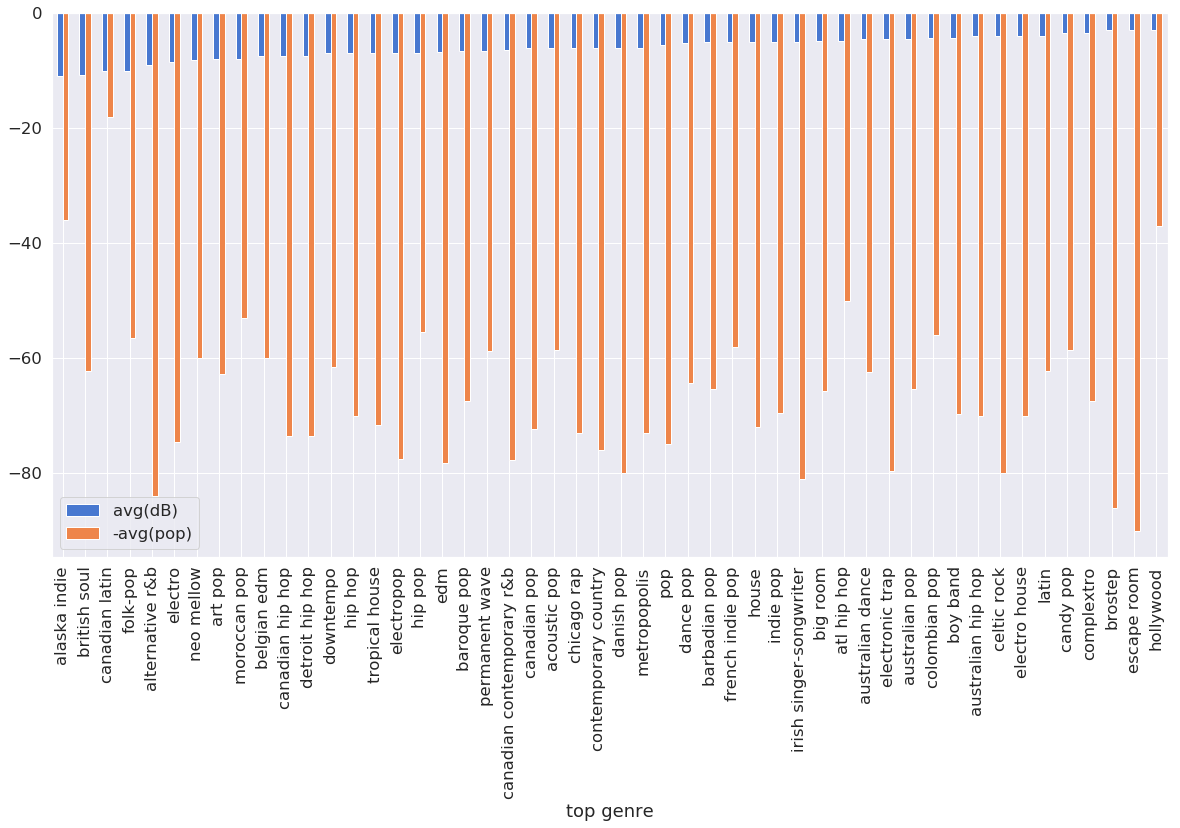

In [14]:
data_filter = pysqldf("""select `top genre`, avg(dB), -avg(pop) from data
group by 1
order by 2""")
data_filter.set_index('top genre').plot(kind = "bar", figsize = (20,10))

### * Upon listening to a few escape room songs, I did feel they were louder that other genres. You can sample a few songs at [Every noise](http://everynoise.com)
### * Over the years the songs are getting mellower on an average
### * Loudness of a song has a mild correlation to the popularity, meaning loudness only slightly affects the popularity.

In [15]:
print(pysqldf("""select title, artist from data where `top genre` = 'escape room'"""))

                                        title artist
0                                 Truth Hurts  Lizzo
1  Good as Hell (feat. Ariana Grande) - Remix  Lizzo


Correlation coefficient is 0.1064 with a p-value of 0.01
We can say that there's very little relation between energy of the song and how groovy it is!


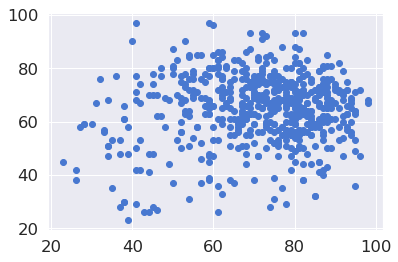

In [16]:
data_filter = data[(data['nrgy'] > 20) & (data['dnce'] > 20)]
plt.scatter(x = data_filter['nrgy'], y = data_filter['dnce'])
corr, p = pearsonr(x = data_filter['nrgy'], y = data_filter['dnce'])
print("Correlation coefficient is %0.4f with a p-value of %0.2f" %(corr, p))
print("We can say that there's very little relation between energy of the song and how groovy it is!")

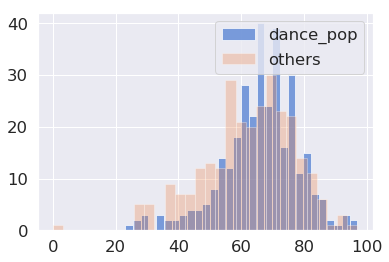

In [17]:
dance_pop = data[data['top genre'] == 'dance pop']
others = data[data['top genre'] != 'dance pop']
x = dance_pop['dnce']
y = others['dnce']
plt.hist(x, bins = 30, alpha=0.7, label='dance_pop')
plt.hist(y, bins = 30, alpha=0.3, label='others')
plt.legend(loc='upper right')
plt.show()

In [18]:
stat, p = ttest_ind(a = dance_pop['dnce'], b = others['dnce'], equal_var=False)
print("p-value is %0.3f" %p)

p-value is 0.002


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


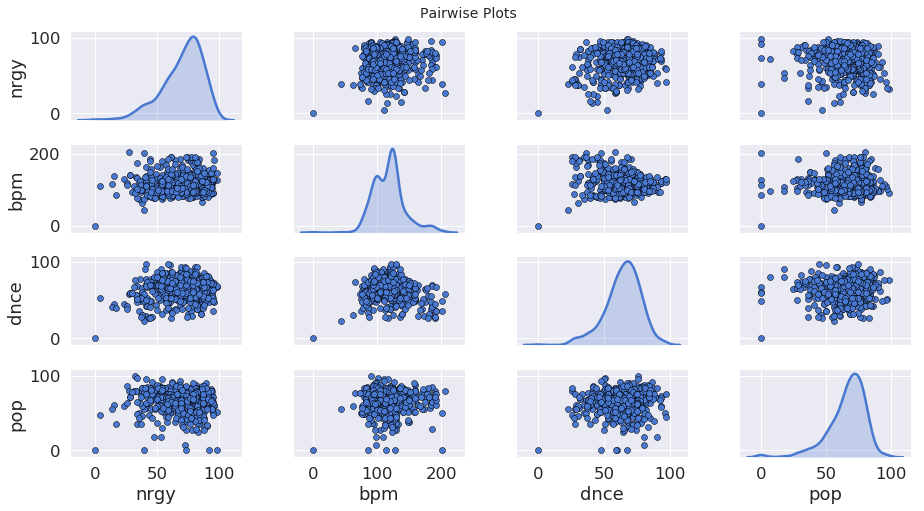

In [19]:
cols = ['nrgy', 'bpm', 'dnce', 'pop']
pp = sns.pairplot(data[cols], size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots', fontsize=14)

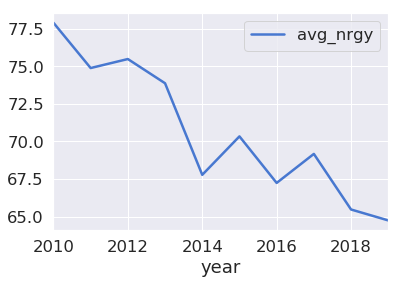

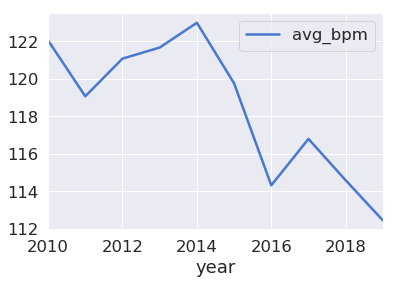

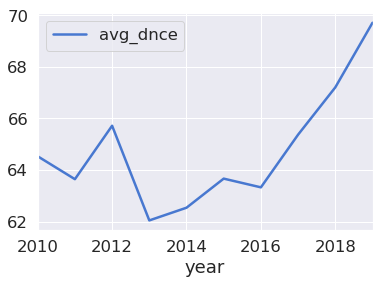

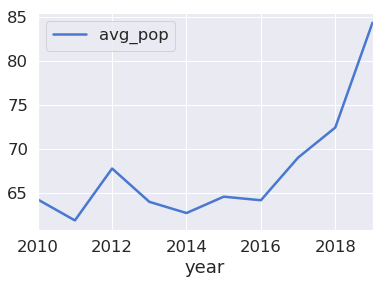

In [20]:
for col in cols:
    q = "select year, avg(%s) as avg_%s from data "%(col,col)
    q+= "group by 1 order by 1"
#     print(q)
    data_filter = pysqldf(q)
    q = "avg_%s"%(col)
    data_filter.set_index('year')[[q]].plot()
    plt.show()

### * The dance_pop very groovy genre is very different from other songs on the chart, in terms of the song's danceability. as we can see from the p-value(t-test for a large sample size)
### * One observation, all the songs are very similiar in nature to each other. We can probably verify this claim later on by running a K-Means clustering
### * a very weird trend is coming out from this dataset, danceability is increasing over the year even though the energy of the songs show a downwards trend
### * A thing to notice here is: Average popularity has been increasing. A possible explanation for such a trend is the popularity value is being constantly updated and the data shows the current popularity of the song rather than it's peak popularity

### Using Doc2Vec model from gensim we convert the title to a vector of length 10. For this we first train the model using the corpus of title that we already have.

In [21]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data['title'])]

In [22]:
documents[1]

TaggedDocument(words='Love The Way You Lie', tags=[1])

In [23]:
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1, workers=4)

In [24]:
vector = model.infer_vector(["Love The Way You Lie"])

In [25]:
vector

array([ 0.00818931, -0.0275682 , -0.0231054 , -0.00776047,  0.03071333,
        0.04898221, -0.01969212, -0.03962082,  0.03006365, -0.00596482],
      dtype=float32)

In [26]:
vector = [model.infer_vector([i]) for i in list(data['title'])]
np.array(vector).shape

(603, 10)

### To visualize the similarity between the songs on the chart, we'll leverage T-SNE algorithm. But for this we need to find cluster

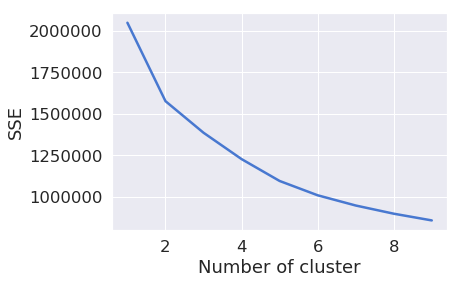

In [27]:
import pandas as pd
# from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
pop = pd.qcut(data['pop'], q= 10, labels = False)
data_filter = data.drop(['artist', 'title','Unnamed: 0', 'pop'], axis = 1)
data_filter = pd.get_dummies(data_filter, prefix = 'top_genre', columns = ['top genre'], drop_first= True)
data_filter = data_filter.to_numpy()

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data_filter)
    clusters = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

### We will cluster the data into two groups as the elbow is formed at 2 also we drop popularity index for clustering as popularity is updated regularly!

In [28]:
# pop = pd.qcut(data['pop'], q= 10, labels = False)
data_filter = data.drop(['artist', 'title','Unnamed: 0', 'pop'], axis = 1)
data_filter = pd.get_dummies(data_filter, prefix = 'top_genre', columns = ['top genre'], drop_first= True)
# year = data_filter['year']
# data_filter = data_filter.drop(['year'], axis = 1)
data_filter = data_filter.to_numpy()
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(data_filter)
clusters = kmeans.labels_
# data_filter

In [29]:
data_filter = np.concatenate((data_filter,vector), axis = 1)
data_filter.shape

(603, 69)

In [30]:
# Utility function to visualize the outputs of PCA and t-SNE

def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [31]:
time_start = time.time()

fashion_tsne = TSNE(perplexity = 10, learning_rate = 100, n_iter = 5000, random_state=RS).fit_transform(data_filter)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


t-SNE done! Time elapsed: 17.256133556365967 seconds


In [32]:
fashion_tsne.shape

(603, 2)

(<Figure size 576x576 with 1 Axes>,
 [Text(4.413884, -11.414605, '0'), Text(-16.84471, 65.134575, '1')])

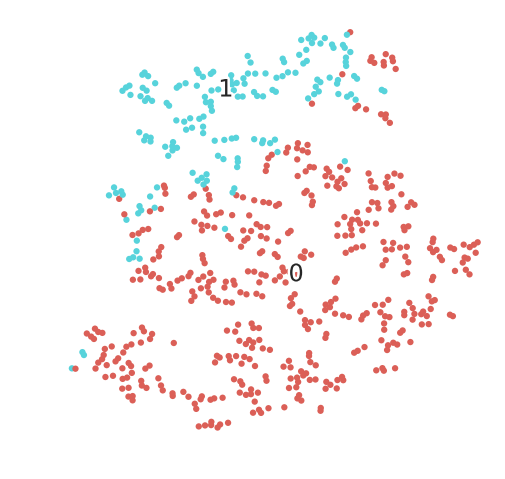

In [33]:
fashion_scatter(fashion_tsne, clusters)